In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from random import random
import glob
%matplotlib inline

### Dataset retrieval and exploration functions

In [9]:
def retrieveImagePathList(folder_regx):
    path_list = []
    for i in glob.glob(folder_regx, recursive=True):
        path_list.append(i)
    return path_list

def exploreDataset(car_glob, not_car_glob):
    dataset_dict = {}
    dataset_dict["car_count"] = len(car_glob)
    dataset_dict["not_car_count"] = len(not_car_glob)
    sample_car_image = cv2.imread(car_glob[int(random() * dataset_dict["car_count"])])
    sample_not_car_image = cv2.imread(not_car_glob[int(random() * dataset_dict["not_car_count"])])

    dataset_dict["car_img_shape"]  = sample_car_image.shape
    dataset_dict["car_img_type"]  = sample_not_car_image.dtype

    dataset_dict["not_car_img_shape"]  = sample_car_image.shape
    dataset_dict["not_car_img_type"]  = sample_not_car_image.dtype
    return dataset_dict

# Retrieve the dataset and view some basic info on it
def get_dataset():
    car = retrieveImagePathList('vehicles/vehicles/**/*.png')
    notCar = retrieveImagePathList('non-vehicles/non-vehicles/**/*.png')
    dataInfo = exploreDataset(car,notCar)
    print("The datset has these parameters: ")
    print("Number of car images\t\t", dataInfo["car_count"])
    print("Number of not car images\t", dataInfo["not_car_count"])
    print("Shape of the car images\t\t", dataInfo["car_img_shape"])
    print("Datatype of the car images\t", dataInfo["car_img_type"])
    print("Shape of the not car images\t", dataInfo["not_car_img_shape"])
    print("Datatype of the not car images\t", dataInfo["not_car_img_type"])
    print("Dataset size difference\t\t",
        1-(abs((dataInfo["car_count"]-dataInfo["not_car_count"])/(dataInfo["car_count"]+dataInfo["not_car_count"]))*100),"%" )
    # And show some example images from each
    car_image = cv2.imread(car[int(random() * dataInfo["car_count"])])
    car_image = cv2.cvtColor(car_image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.subplot(121)
    plt.title("Vehicle")
    plt.imshow(car_image)
    not_car_image = cv2.imread(notCar[int(random() * dataInfo["not_car_count"])])
    not_car_image = cv2.cvtColor(not_car_image, cv2.COLOR_BGR2RGB)
    plt.subplot(122)
    plt.title("Not a Vehicle")
    plt.imshow(not_car_image)
    return car, notCar, dataInfo

In [10]:
# Define a color space dict. All image reads done by cv2.imread()
cs = { 'HSV':    cv2.COLOR_BGR2HSV, 
       'YUV':    cv2.COLOR_BGR2YUV, 
       'YCrCb':  cv2.COLOR_BGR2YCrCb,
       'LUV':    cv2.COLOR_BGR2LUV,
       'HLS':    cv2.COLOR_BGR2HLS }
# Declare these globally, so there isn't confusion
# pixels per cell
ppc = 8 
# cells per block
cpb = 1
# orient
ori = 8
# hist bins
hb = 30
# hist range
hr = (0, 256)
# downsample size
rsize = (30,30)
# color space
cspace = "LUV"
   
# Define a function to return HOG features
def hog_by_chan(img,pix_per_cell=ppc,cell_per_block=cpb,orient=ori, rav=True, 
                c_space='LUV', chans=[1,2,3], vis=False):
    """
    Compute individual channel HOG features for the image
    """
    img = cv2.cvtColor(img, cs[c_space]).astype(np.float32)
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    hoglist=[]
    imagelist=[]
    if 1 in chans:
        h1 = hog(ch1,orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                        cells_per_block=(cell_per_block,cell_per_block), visualise=vis,
                        feature_vector=False,block_norm='L2-Hys')
        hoglist.append(h1[0])
        if vis:
            imagelist.append(h1[1])
    if 2 in chans:
        h2 = hog(ch2,orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                    cells_per_block=(cell_per_block,cell_per_block), visualise=vis,
                    feature_vector=False,block_norm='L2-Hys')
        hoglist.append(h2[0])
        if vis:
            imagelist.append(h2[1])
    if 3 in chans:
        h3 = hog(ch3,orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                    cells_per_block=(cell_per_block,cell_per_block), visualise=vis,
                    feature_vector=False,block_norm='L2-Hys')
        hoglist.append(h3[0])
        if vis:
            imagelist.append(h3[1])
    if rav:
        hlist = []
        for HOG in hoglist:
            hlist.append(HOG.ravel())
        if vis:
            return np.hstack(tuple(hlist)), imagelist
        return np.hstack(tuple(hlist))
    elif vis:
        return hoglist,imagelist
    return hoglist

### Spacial and color histogram functions

In [22]:
# Define a function to compute binned color features  
def bin_spatial(img, color_space=cspace, size=rsize):
    # Convert image to new color space (if specified)
    if color_space != 'BGR': image = cv2.cvtColor(img,cs[color_space])
    else: image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(image,size).ravel()
    # Return the feature vector
    return features

def color_hist(img, nbins=hb, bins_range=hr):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def normalize_features(car_features, not_car_features):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, not_car_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply and return the scaler to X
    return X, X_scaler.transform(X)

The datset has these parameters: 
Number of car images		 8792
Number of not car images	 8968
Shape of the car images		 (64, 64, 3)
Datatype of the car images	 uint8
Shape of the not car images	 (64, 64, 3)
Datatype of the not car images	 uint8
Dataset size difference		 0.009009009009009028 %


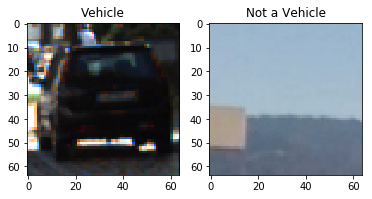

In [12]:
carFiles, notCarFiles, dataInfo = get_dataset()

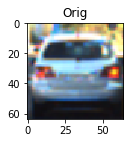

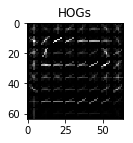

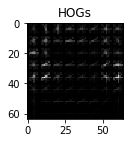

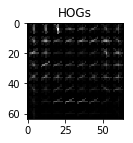

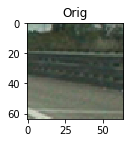

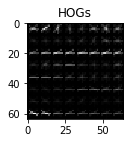

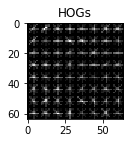

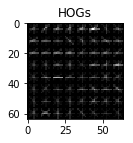

In [13]:
row = 2
col = 5
sp = 1
width =10
height =10
for image in(cv2.imread(carFiles[int(random() * dataInfo["car_count"])]),cv2.imread(notCarFiles[int(random() * dataInfo["not_car_count"])])):
    sampleFeatures, HOGImg = hog_by_chan(image,vis=True)
    fig = plt.figure(figsize=(width,height))
    plt.subplot(row,col,sp)
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.title("Orig")
    sp+=1
    for hImg in HOGImg:
        fig = plt.figure(figsize=(width,height))
        plt.subplot(row,col,sp)
        plt.imshow(hImg, cmap="gray")
        plt.title("HOGs")
        sp = 1
        plt.show()

# prevent accidentally using these again
image, rsizedImg, grayImg, HOGImg, sampleFeatures = None,None,None,None,None

In [14]:
def extract_features(image, cspace=cspace, spatial_size=rsize,
                        hist_bins=hb, hist_range=hr, Hogs=True):
    # Assure that all images are of the same size and type
    image = cv2.resize(image,(64,64)).astype(np.float32)
    # Apply bin_spatial() to get spatial color features
    s_features = bin_spatial(image, size=spatial_size)
    # Apply color_hist() to get color histogram features
    hist_features = color_hist(image, nbins=hist_bins, bins_range=hist_range)
    if Hogs:
        # Apply get_hog_features to get HOG features
        hog_features = hog_by_chan(image,rav=True)
        # Return feature vectors
        return np.concatenate((s_features,hist_features,hog_features))
    return np.concatenate((s_features,hist_features))

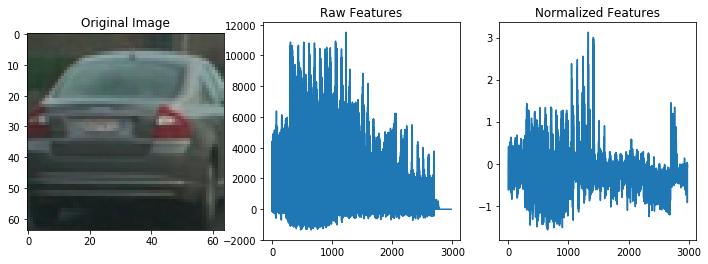

In [16]:
import os
import pickle
if os.path.exists("pantry/features.p"):
    features = pickle.load( open( "pantry/features.p", "rb" ) )
    carFeatures = features["car"]
    notCarFeatures = features["notCar"]
else:
    for file in carFiles:
        carImg = cv2.imread(file)
        carFeatures.append(extract_features(carImg))
    for file in notCarFiles:
        notCarImg = cv2.imread(file)
        notCarFeatures.append(extract_features(notCarImg))
    features = {}
    features["car"] = carFeatures
    features["notCar"] = notCarFeatures
    pickle.dump( features, open( "features.p", "wb" ) )

raw, normalizedFeatures = normalize_features(carFeatures,notCarFeatures)
car_ind = int(random() * dataInfo["car_count"]//4)
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(carFiles[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(raw[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(normalizedFeatures[car_ind])
plt.title('Normalized Features')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

def norm_split_shuffle(car_features, not_car_features, labels):
    # Create an array stack of feature vectors
    X = np.vstack((car_features, not_car_features)).astype(np.float32)                        
    # Get a seperate Training and Test dataset
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size=0.17,random_state=rand_state)
   
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, X_scaler


In [18]:
features = pickle.load( open( "pantry/features.p", "rb" ) )
carFeatures = features["car"]
notCarFeatures = features["notCar"]
labels = features["labels"]
X_train, X_test, y_train, y_test, X_scaler = norm_split_shuffle(carFeatures,notCarFeatures,labels)
paramVals = pickle.load( open( "pantry/paramVals.p", "rb" ) )
C = paramVals["C"]
gamma = paramVals["gamma"]
classifier = pickle.load( open( "pantry/classifier.p", "rb" ) )
clf = classifier['classifier']


In [30]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None or y_start_stop[0] == None:
        x_start_stop=[0,img.shape[1]]
        y_start_stop=[0,img.shape[0]]
    # Compute the span of the region to be searched
    span = (x_start_stop[1]-x_start_stop[0], y_start_stop[1]-y_start_stop[0])
    # Compute the number of pixels per step in x/y
    pix_per_step = ((xy_window[0]*xy_overlap[0]),(xy_window[1]*xy_overlap[1]))
    # Compute the number of windows in x/y
    windows = (1+(span[0]-xy_window[0])//pix_per_step[0],1+(span[1]-xy_window[1])//pix_per_step[1])
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for xi in range(int(windows[0])):
        for yi in range(int(windows[1])):
            # Calculate each window position
            xy1 = (int(x_start_stop[0]+xi*pix_per_step[0]),int(y_start_stop[0]+yi*pix_per_step[1]))
            xy2 = (int(xy1[0]+xy_window[0]),int(xy1[1]+xy_window[1]))
            window_list.append((xy1,xy2))
        # Append window position to list
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thickness=thick)
    # return the image copy with boxes drawn
    return draw_img 

In [97]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler):   
    draw_img = np.copy(img)
    img = img.astype(np.float32)
    boxes = []
    
    # Only searching relevant parts of the image
    imgToSearch = img[ystart:ystop,:,:]
    imshape = imgToSearch.shape

    if scale != 1:
        imgToSearch = cv2.resize(imgToSearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        imshape = imgToSearch.shape
    
    windows = slide_window(imgToSearch)
    
    # Compute individual channel HOG features for the entire (cropped) image
    HOG = hog_by_chan(imgToSearch, rav=False)
    # hogger = get_hog_features(imgToSearch, feature_vec=False)
    nblocks_per_window = (64 // ppc) - cpb + 1
    # Cells per step
    cps = ppc//2
    for window in windows:
        # Extract HOG for this patch
        x_y = window[0]
        x1_y1 = window[1]
#         ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window
        hog_feat = []
        for i,h in enumerate(HOG):
            print(i,":",x_y[1]//cps,x1_y1[1]//cps+nblocks_per_window,"\t", x_y[0]//cps,x1_y1[0]//cps+nblocks_per_window)
            hog_feat = h[x_y[1]//cps:x1_y1[1]//cps+nblocks_per_window, x_y[0]//cps:x1_y1[0]//cps+nblocks_per_window].ravel() 
        hog_features = np.hstack(tuple(hog_feat))
        # Extract the image patch
        subimg = cv2.resize(imgToSearch[x_y[1]:x1_y1[1], x_y[0]:x1_y1[0]], (64,64))
#         hog_features = hog_by_chan(subimg, rav=True)
        
        # Get color features    
        s_and_hist_feats = extract_features(subimg,Hogs=False)
        # concatenate and scale features to dataset
        test_features = X_scaler.transform(np.concatenate((s_and_hist_feats, hog_features)).reshape(1, -1))   

        # Scale features and make a prediction
        test_prediction = svc.predict(test_features)
        
        if test_prediction == 1:
            xbox_left = np.int(x_y[0]*scale)
            ytop_draw = np.int(x_y[1]*scale)
            win_draw = np.int(64*scale)
            boxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])

    draw_img = draw_boxes(draw_img, boxes)                
    return draw_img

In [98]:
image = cv2.imread("test/example-image.png")
window_img = find_cars(image, 400,720,4,clf,X_scaler)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg                    
plt.figure()
plt.imshow(window_img)
plt.show()

0 : 0 24 	 0 24
1 : 0 24 	 0 24
2 : 0 24 	 0 24
0 : 0 24 	 8 32
1 : 0 24 	 8 32
2 : 0 24 	 8 32


ValueError: need at least one array to concatenate